## BDP Part 2

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import time
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
## Read processed data
bucket_name = 'msca-bdp-students-bucket'
prefix = 'shared_data/sravani/processed'

df = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

23/03/06 21:16:12 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
#df.printSchema()

In [7]:
# Keywords for government organizations
govt_keywords = ['republic', 'congress', 'parliament', 'senate', 'president', 'democrat', 'republican',
                 'prime minister', 'constitution', 'MLA', 'mla', 'gov', 'u.s.', 'U.S.', 'US', 'united states', 
                 'federal', 'state', 'department', 'agency', 'ministry']

# Keywords for news organizations
news_keywords = ['news', 'newspaper', 'times', 'post', 'journal', 'gazette', 'chronicle', 'press', 
                 'daily', 'weekly', 'report', 'broadcast', 'radio', 'television']

# Keywords for celebrity organizations
celeb_keywords = ['actor', 'singer', 'writer', 'musician', 'actress', 'author', 'golfer', 'athlete',
                  'comedian', 'performer', 'director', 'producer', 'model']

# Keywords for education organizations
edu_keywords = ['school', 'university', 'college', 'learning', 'academy', 'institute', 'research', 
                'teaching', 'master', 'graduate', 'undergraduate', 'elementary', 'secondary', 
                'high school', 'middle school', 'teacher', 'professor', 'student', 'education']

# Keywords for non-profit organizations
nonprofit_keywords = ['nonprofit', 'charity', 'foundation', 'ngo', 'humanitarian', 'aid']

# Concatenate keywords with OR operator
govt_regex = '|'.join(["(" + k + ")" for k in govt_keywords])
news_regex = '|'.join(["(" + k + ")" for k in news_keywords])
celeb_regex = '|'.join(["(" + k + ")" for k in celeb_keywords])
edu_regex = '|'.join(["(" + k + ")" for k in edu_keywords])
nonprofit_regex = '|'.join(["(" + k + ")" for k in nonprofit_keywords])

# Apply organization labels to DataFrame
df_orgs = df_users \
    .withColumn('Organisation', 
                when(df_users['user_verified'] == False, 'Other')
                .when((df_users['user_name'].rlike(news_regex)) | (df_users['user_description_lower'].rlike(news_regex)), 'News')
                .when((df_users['user_name'].rlike(govt_regex)) | (df_users['user_description_lower'].rlike(govt_regex)), 'Government')
                .when((df_users['user_description_lower'].rlike(celeb_regex)) & (df_users['followers_count'] > 25000), 'Celebrity')
                .when((df_users['user_name'].rlike(edu_regex)) | (df_users['user_description_lower'].rlike(edu_regex)), 'Education')
                .when((df_users['user_name'].rlike(nonprofit_regex)) | (df_users['user_description_lower'].rlike(nonprofit_regex)), 'Nonprofit')
                .when(df_users['followers_count'] > 1000, 'Influencer')
                .otherwise('Other')) \
    .drop('user_description_lower')


In [8]:
#df_orgs.show(5)

In [8]:
# Count the number of original tweets per user
df_tweet_count = df_orgs.filter((df_orgs['user_verified'] == True) & (df_orgs['if_retweet'] == False))

# Sort by count in descending order
df_tweet_count = df_tweet_count.orderBy(desc('total_count'))

# Show the top 10 most prolific original tweeters
df_tweet_count.show(10, truncate=False)


+-----------+----------+-----------------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------------+-----------+-----------+-------------+---------------+----------------+---------------+------------+
|user_id_str|if_retweet|user_name              |user_screen_name|user_description                                                                                                                                                |user_verified|user_location           |total_count|avg_retweet|total_retweet|followers_count|popularity_score|relevance_score|Organisation|
+-----------+----------+-----------------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------------+---

In [9]:
# Count the number of retweets per user
df_retweet_count = df_orgs.filter((df_orgs['user_verified'] == True) & (df_orgs['if_retweet'] == True) & (df_orgs['total_count'] > 100))

# Sort by count in descending order
df_retweet_count = df_retweet_count.orderBy(desc('avg_retweet'))

# Show the top 10 most prolific tweeters by retweets
df_retweet_count.show(10, truncate=False)

+-------------------+----------+----------------------------------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------------------+-----------+------------------+-------------+---------------+--------------------+-------------------+------------+
|user_id_str        |if_retweet|user_name                         |user_screen_name|user_description                                                                                                                                             |user_verified|user_location                 |total_count|avg_retweet       |total_retweet|followers_count|popularity_score    |relevance_score    |Organisation|
+-------------------+----------+----------------------------------+----------------+--------------------------------------------------------------------------------------------------------------

In [28]:
from pyspark.sql.functions import *
 
# Fill missing values in the 'Organisation' column with 'Other'
df_orgs = df_orgs.withColumn('Organisation', when(col('Organisation').isNull(), 'Other').otherwise(col('Organisation')))
 
# Select only rows where 'user_verified' is True and select certain columns
user_verified = df_orgs.filter(col('user_verified') == True).select('Organisation', 'user_id_str', 'total_count', 'total_retweet')
 
# Calculate the total number of tweets per organization
plt_tweets = user_verified.groupBy('Organisation').agg(sum('total_count').alias('tweets_count'))
 
# Calculate the average number of retweets per tweet per organization
plt_retweets = user_verified.groupBy('Organisation').agg(avg('total_retweet').alias('avg_total_retweets'))


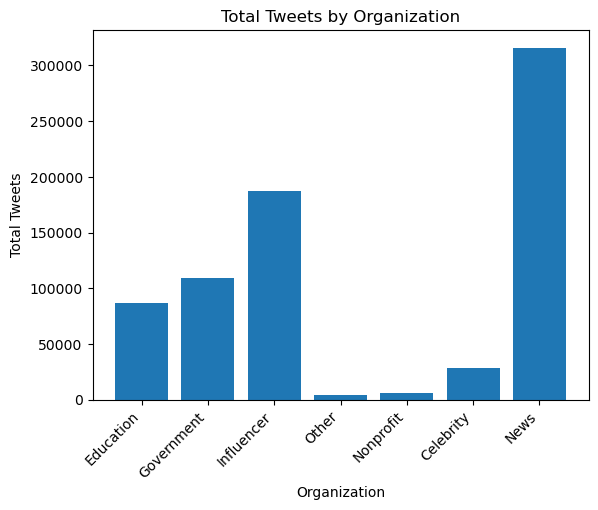

In [ ]:
import matplotlib.pyplot as plt
 
# Convert the 'tweets_count' column to float data type
plt_tweets = plt_tweets.withColumn("tweets_count", col("tweets_count").cast("float"))
 
# Create a bar chart of the total tweets per organization
plt.bar(x=plt_tweets.select('Organisation').rdd.flatMap(lambda x: x).collect(), height=plt_tweets.select('tweets_count').rdd.flatMap(lambda x: x).collect())
 
# Add labels for the x-axis, y-axis, and title
plt.xlabel('Organization')
plt.ylabel('Total Tweets')
plt.title('Total Tweets by Organization')
 
# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45, ha='right')
 
# Display the plot
plt.show()


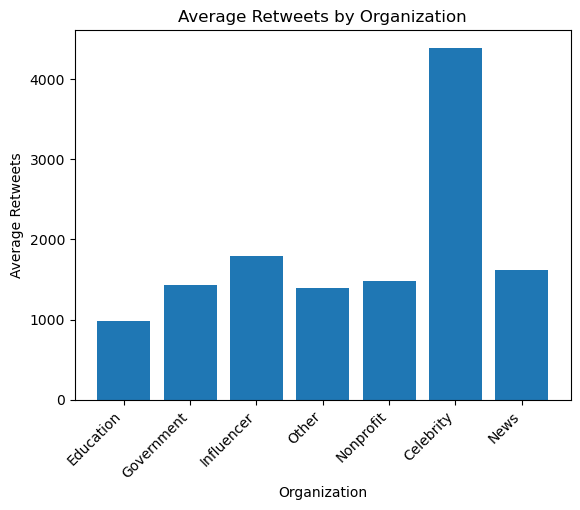

In [ ]:
import matplotlib.pyplot as plt
 
# Convert the 'tweets_count' column to float data type
plt_retweets = plt_retweets.withColumn("avg_total_retweets", col("avg_total_retweets").cast("float"))
 
# Create a bar chart of the total tweets per organization
plt.bar(x=plt_retweets.select('Organisation').rdd.flatMap(lambda x: x).collect(), height=plt_retweets.select('avg_total_retweets').rdd.flatMap(lambda x: x).collect())
 
# Add labels for the x-axis, y-axis, and title
plt.xlabel('Organization')
plt.ylabel('Average Retweets')
plt.title('Average Retweets by Organization')
 
# Rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=45, ha='right')
 
# Display the plot
plt.show()


In [ ]:
# Filter the dataframe to get the top influential users who are verified and haven't retweeted
inf_users = df_orgs.filter((df_orgs['user_verified'] == True) & (df_orgs['if_retweet'] == False)) \
    .orderBy('total_count', ascending=False) \
    .limit(10000) \
    .select('user_id_str', 'Organisation', 'total_count', 'total_retweet')

# Filter the dataframe to get the top 100 influential users who are verified, have retweeted, and have more than 100 tweets
inf_users_retw = df_orgs.filter((df_orgs['user_verified'] == True) & (df_orgs['if_retweet'] == True) & (df_orgs['total_count'] > 100)) \
    .orderBy('avg_retweet', ascending=False) \
    .limit(10000) \
    .select('user_id_str', 'Organisation', 'total_count', 'total_retweet', 'avg_retweet')

# Aggregate the total tweets and average retweets per organization and convert to Pandas dataframe
inf_users_df = inf_users.groupBy('Organisation').agg(sum('total_count').alias('total_tweets')).toPandas()
inf_users_retw_df = inf_users_retw.groupBy('Organisation').agg(avg('total_retweet').alias('avg_total_retweets')).toPandas()


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


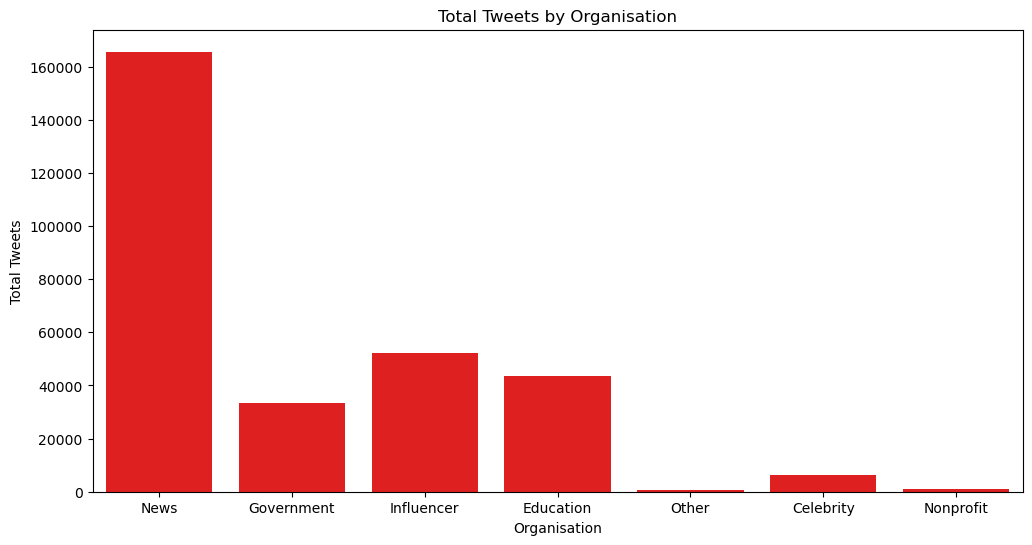

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Organisation', y='total_tweets', data=inf_users_df, color='red')
plt.title('Total Tweets by Organisation')
plt.xlabel('Organisation')
plt.ylabel('Total Tweets')
plt.show()


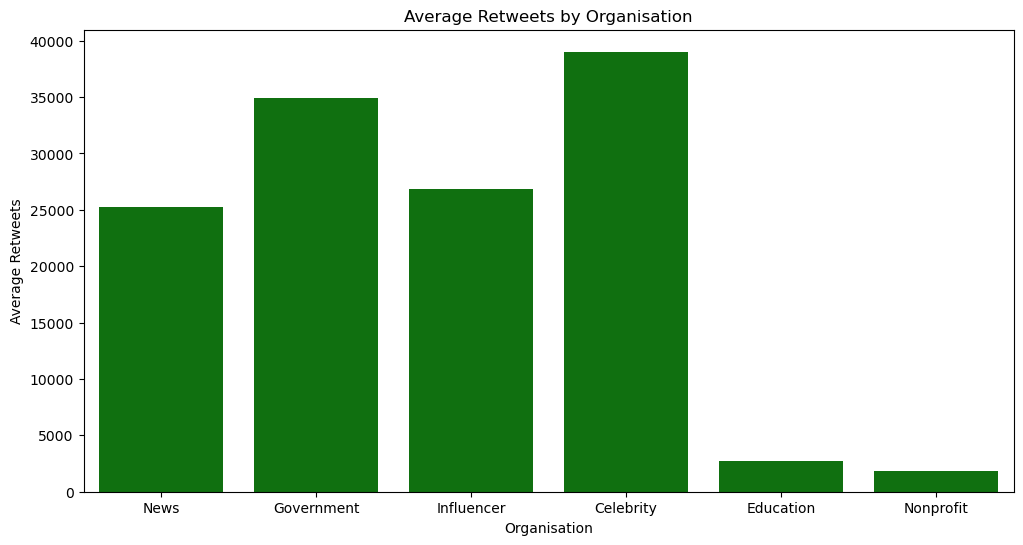

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Organisation', y='avg_total_retweets', data=inf_users_retw_df, color='green')
plt.title('Average Retweets by Organisation')
plt.xlabel('Organisation')
plt.ylabel('Average Retweets')
plt.show()


In [ ]:
bucket_name = 'msca-bdp-students-bucket'
prefix = 'shared_data/sravani/orgs'

df_orgs.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_name + '/' + prefix + '/')

In [ ]:
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs
